<a href="https://colab.research.google.com/github/bezhvin/Optimization-with-Tensorflow/blob/main/SimpleExampleNoConstraint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import math
import numpy as np
from six.moves import xrange
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from scipy.stats import norm

In [29]:
#!pip install git+https://github.com/google-research/tensorflow_constrained_optimization
import tensorflow_constrained_optimization as tfco

### Simple non constrained optimization

Let's start with a simple example of fitting some coefficients for a quadratic function:
$$y = ax^2 + bx+c$$
This is basically a simple plynomial fitting and can be done mathematically as it is a convex optimization. But for the sake of illustration let's assume we want to the find proper prameters ${a,b,c}$ via some iterative gradient based optimization.
Assuming the ground truth parameters are ${a=3, b=.5, and\ c=4}$, we have
$$y = 3x^2 + .5x+4$$
Let's generate the training data with 50 samples:

Text(0.5, 0, 'X')

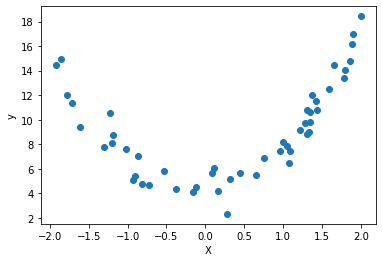

In [30]:
training_size = 50
y_clean = lambda x: 3*x**2 + .5*x + 4 

## randomly generating X
X= np.random.uniform(low=-2, high=2,size=training_size).astype(np.float32) ## input 
## and then generating the corresponding y
y = y_clean(X) + np.random.normal(size=training_size).astype(np.float32) # output --> we added some noise to make it more realistic
## how does it look like?
plt.scatter(X, y)
plt.ylabel('y'); plt.xlabel('X')

First, it is helpful to rewrite the problem in a matrix multiplication format 
$$y = AX $$
this helps the code to be cleaner and is more inline with what tensorflow expects. In general we know computers are good at matrix multiplication so we always should try to frame our problems in this way!
Thus, we can rewrite it as:

$$
y = \begin{bmatrix}  
a & b & c  
\end{bmatrix} 
\begin{bmatrix}  
x^2\\  
x\\  
1\\  
\end{bmatrix}$$

In [31]:
# y=AX
X_matrix = np.array([X**2, X, np.ones(X.size)]).T

In [32]:
# making constant tensors for the training data
y_ground_truth = tf.constant(y, dtype=tf.float32)
X_ground_truth = tf.constant(X_matrix, dtype=tf.float32)

In [33]:
# initializing the parameters a,b,and c as tensor variables
# this is the variable which will be updated during the optimization
weights = tf.Variable(tf.random_normal_initializer()(shape=[3], dtype=tf.float32))

In [34]:
# the estimated y (or prediction for y) using the weights we want to optimize
y_prediction = tf.tensordot(X_ground_truth, weights, axes=1)

To optimize the parameters we need to define an objective function. actually we optimize the parameters with respect to this objective function. In our example, the least square could be helpful:
$$ mean((y - y_{prediction})^2) $$

In [35]:
## tensorflow has already made many of the known objective functions available, e.g. in tf.compat.v1.losses
## but you may still wrtie down the objective formula yourself. Both ways are shown below
def objective():
    y_prediction = tf.tensordot(X_ground_truth, weights, axes=1)
    return tf.math.reduce_mean((y_ground_truth - y_prediction)**2)
#     return tf.compat.v1.losses.mean_squared_error(labels=y_ground_truth,
#                                                  predictions=y_prediction)

There are many gradient descent optimization algorithms and fortunately almost all are available in tensorflow. The choice of the algorithm depends on the task. In our example, all would work properly (some faster some slower).

In [36]:
# optimization
optimizer = tf.keras.optimizers.Adagrad(learning_rate=1.0)
var_list=[weights]
for ii in range(100):
    optimizer.minimize(objective, var_list=var_list)
    #print(weights.numpy()) --> activate if you want to see how the parameters get updated
print(f'the parameters are: [a, b, c] = {(weights.numpy())}')

the parameters are: [a, b, c] = [3.0566504  0.49964973 4.087926  ]


These parameters are close to the ground truth coefficients, right? the small difference is due to the noise we added to the training data.

Let's look at the fit then:

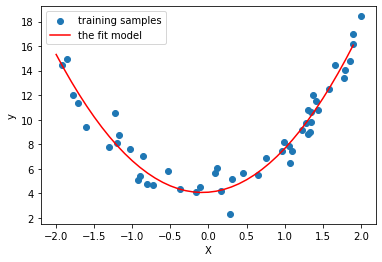

In [37]:
x=np.arange(-2,2,.1)
y_estimated_no_constraint = weights[0]*x**2 + weights[1]*x + weights[2]

plt.scatter(X, y, label='training samples')
plt.plot(x,y_estimated_no_constraint, color='r', label='the fit model' )
plt.ylabel('y'); plt.xlabel('X')
plt.legend()

### Simple constrained optimization

With constrained optimization you impose some constraints on the problem. It may be done in different ways; for example, you may want some parameters to be in a certain range, or a function of the paramaters follow a certain equation.
Thanks to the TFCO interface, it is somewhat straightforward to implement. Let's try it then!


In this section we practice two scenarios by imposing constraints on the curve fitting example above.
In the first scenario, the constraint is directly applied on one of the parameters, say $c$ to be between  0 and 1:
$$0<c<1$$

before jumping into the code, let's highlight some points on how to frame your constrained optimization with TFCO:

* The constraints should be formed as $a<0$. Therefore in this example, we have
$$-c<0$$
$$c-1<0$$
thus, you are having 2 constraints from the TFCO view!
* If you have multiple constraints, you need to stack them all.
* We still use one of the gradient based optimization algorithms; however, in the framework of LagrangianOptimizer.
* The LagrangianOptimizer introduces another coefficient (Lagrangian multiplier), which should be optimized together to the updatable parameters.

Let's see how we can implement it. Please also note to the comments in the code.

In [38]:
# lets assume 0<c<1:
class SimpleConstrainedProblem(tfco.ConstrainedMinimizationProblem): # inheriting from the tfco.ConstrainedMinimizationProblem
    def __init__(self, y, weights):
        self.y = y
        self.weights = weights
        
    @property
    def num_constraints(self):
        return 2 # this refers to the 2 equations we derived for the constraints on c
    
    def objective(self): # like before, nothing is changed here
        predictions = tf.tensordot(X_ground_truth, self.weights, axes=1)
        return tf.compat.v1.losses.mean_squared_error(labels=self.y,
                                                     predictions=predictions)
    
    def constraints(self): 
        a,b,c = self.weights
        constraint_1 = c - 1 # constraint1 is c-1 < 0
        constraint_2 = -c    # constraint2 is -c < 0
        constraint = tf.stack([constraint_1, constraint_2]) # stacking the constraints
        return constraint
    

In [39]:
## initializing the parameters
weights = tf.Variable(tf.random_normal_initializer()(shape=[3], dtype=tf.float32))
## instantiating the problem
problem = SimpleConstrainedProblem(y_ground_truth, weights)

In [40]:
# from the TFCO interface
optimizer = tfco.LagrangianOptimizer(tf.optimizers.Adagrad(learning_rate=1.),
                                    num_constraints=problem.num_constraints)
# all the parameters to be optimized, problem.trainable_variables contains a,b, and c and optimizer.trainable_variables() is
# the Lagrangian multiplier
var_list = list(problem.trainable_variables) + [optimizer.trainable_variables()]

In [41]:

for ii in range(200):
    optimizer.minimize(problem, var_list=var_list)
    if ii%20==0:
        print(f'[a,b,c] = {problem.weights.numpy()}')

print(f'final [a,b,c] = {problem.weights.numpy()}')

[a,b,c] = [0.9245311 1.0281004 1.0285794]
[a,b,c] = [3.6659741 0.7369278 1.47702  ]
[a,b,c] = [ 4.6075196   0.64890194 -0.34829882]
[a,b,c] = [4.789058   0.47604424 0.0512103 ]
[a,b,c] = [4.440772   0.42658255 1.0304182 ]
[a,b,c] = [4.16819    0.45848596 1.5258653 ]
[a,b,c] = [4.1071067 0.5047258 1.4476546]
[a,b,c] = [4.224653   0.53116935 1.0519158 ]
[a,b,c] = [4.369112  0.525137  0.7482211]
[a,b,c] = [4.4218307 0.50239   0.7352028]
final [a,b,c] = [4.377518   0.48618376 0.91443944]


As we can observe during the optimization we try to minimize the objective and respect the constraints. We already know that the optimized value for c is around 4; however, because of the constraints we applied it cannot get larger than one.

Let's take a look at the fit and compare it with with the one we made without any constraint on the model.

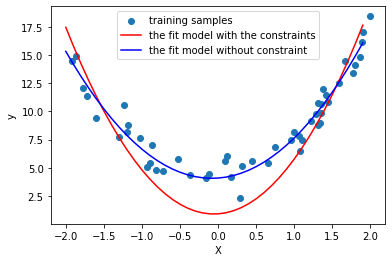

In [42]:
weights = problem.weights
x=np.arange(-2,2,.1)
y_estimated_constraint = weights[0]*x**2 + weights[1]*x + weights[2]

plt.scatter(X, y, label='training samples')
plt.plot(x,y_estimated_constraint, color='r', label='the fit model with the constraints' )
plt.plot(x,y_estimated_no_constraint, color='b', label='the fit model without constraint' )
plt.ylabel('y'); plt.xlabel('X')
plt.legend()

It is apparent that the model with the constraint made a worse fit, because we did not let the c to get close to its optimal value...

##### second scenario: constraint on the output

As mentioned before, we may want to impose a constraint on some functions of the parameters. For example, on the output, or a function of the output.

In the aforementioned curve fitting problem, let's assume we want the predicted values to be always larger than 7:
$$ax^2 + bx+c > 7$$

Then, we need to change the "constraints" method of the class; as you can see below, we benefit from the tf functionalities by finding the minimum value of the predictions and constraining it to be always larger than 7:

In [43]:
class SimpleConstrainedProblem(tfco.ConstrainedMinimizationProblem): # inheriting from the tfco.ConstrainedMinimizationProblem
    def __init__(self, y, weights):
        self.y = y
        self.weights = weights
        
    @property
    def num_constraints(self):
        return 1 # we have only one constraint coming out of the constraints method
    
    def objective(self): # like before, nothing is changed here
        predictions = tf.tensordot(X_ground_truth, self.weights, axes=1)
        return tf.compat.v1.losses.mean_squared_error(labels=self.y,
                                                     predictions=predictions)
    
    def constraints(self): 
        predictions = tf.tensordot(X_ground_truth, self.weights, axes=1)
        min_value = tf.reduce_min(tf.tensordot(X_ground_truth, self.weights, axes=1))
        constraint = 7- min_value  
        return constraint

In [44]:
## initializing the parameters
weights = tf.Variable(tf.random_normal_initializer()(shape=[3], dtype=tf.float32))
## instantiating the problem
problem = SimpleConstrainedProblem(y_ground_truth, weights)

In [45]:
# from the TFCO interface
optimizer = tfco.LagrangianOptimizer(tf.optimizers.Adagrad(learning_rate=1.),
                                    num_constraints=problem.num_constraints)
# all the parameters to be optimized, problem.trainable_variables contains a,b, and c and optimizer.trainable_variables() is
# the Lagrangian multiplier
var_list = list(problem.trainable_variables) + [optimizer.trainable_variables()]

In [46]:
for ii in range(200):
    optimizer.minimize(problem, var_list=var_list)
    if ii%20==0:
        print(f'[a,b,c] = {problem.weights.numpy()}')

print(f'final [a,b,c] = {problem.weights.numpy()}')

[a,b,c] = [1.0271437 1.1315038 1.0419413]
[a,b,c] = [2.839767   0.19037513 5.3419385 ]
[a,b,c] = [2.032863   0.07906467 7.460147  ]
[a,b,c] = [1.3921748  0.17559315 8.711638  ]
[a,b,c] = [1.1046395  0.30844155 9.027046  ]
[a,b,c] = [1.1549597  0.42443675 8.619955  ]
[a,b,c] = [1.4005811  0.52246606 7.851367  ]
[a,b,c] = [1.7141855 0.5540685 7.061677 ]
[a,b,c] = [1.9872538 0.535861  6.4749722]
[a,b,c] = [2.154221   0.49008015 6.194872  ]
final [a,b,c] = [2.1992474  0.43934372 6.2087727 ]


and by plotting:

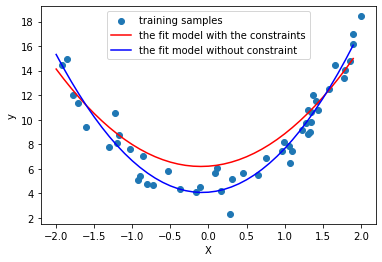

In [47]:
weights = problem.weights
x=np.arange(-2,2,.1)
y_estimated_constraint = weights[0]*x**2 + weights[1]*x + weights[2]

plt.scatter(X, y, label='training samples')
plt.plot(x,y_estimated_constraint, color='r', label='the fit model with the constraints' )
plt.plot(x,y_estimated_no_constraint, color='b', label='the fit model without constraint' )
plt.ylabel('y'); plt.xlabel('X')
plt.legend()

The red curve indicates the fit model with the constraint and it is apparent that the optimization has kept it above the threshold 7!

### A more realistic example (constrained optimization) 

It is also a good practice to look at a more realistic scenario: *fitting a distribution*

Each distribution is characterized by one or more parameters. For example, a normal distribution is described by mean and variance. Noting that if it is a multivariate normal distribution, mean is a vector and variance is a matrix, which is actually the covariance matrix.

Let's start with a one dimensional data, and we want to fit a Gaussian on the data:


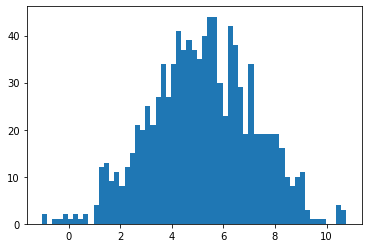

In [213]:
# making training data
## assuming data is drawn from a normal distribution with mean=1 and std=2
sample_size = 1000
ground_truth_mean = 5
ground_truth_std = 2
X = np.random.normal(size=sample_size, loc=ground_truth_mean, scale=ground_truth_std)
## adding some noise to make it more realsitic!
X_ground_truth = (X + np.random.uniform(0,0.25,sample_size)).astype(np.float32)
## and visualizing the data in a histogram form ...
binwidth=0.2
bins = plt.hist(X_ground_truth, bins=np.arange(min(X_ground_truth), max(X_ground_truth) + binwidth, binwidth))

It is important to note that unlike the previous examples, we do not have any target/label to match the model predictions against them. We here would like to put the data $X$ in the following formula:

$$ P(X) = \frac{1}{\sigma\sqrt{2\pi}}  \exp\left( -\frac{1}{2}\left(\frac{X-\mu}{\sigma}\right)^{\!2}\,\right) $$

and then find the parameters $\sigma$ and $\mu$ that maximizes the $P(X)$. 

Let's define the paramaters:


In [214]:
## initializing the parameters with mean=0, and std=1
mu = tf.Variable([0], dtype=tf.float32, name='mean')
sigma = tf.Variable([1], dtype=tf.float32, name='standard dev')

TF follows a minimization procedure. Maximizng $P(X)$ equates to minimizing $-ln P(X)$, which is called *negative log-likeloood*.

$$ -ln P(X) = \frac{1}{2}  \left(\frac{X-\mu}{\sigma}\right)^{\!2}\ +\frac{1}{2}ln2\pi + ln\sigma$$

In the optimization only the terms that include the parameters $\sigma$ and $\mu$ are important, so:

In [215]:
def objective():
    negative_log_like = 0.5*tf.math.square((X_ground_truth - mu)/sigma) + tf.math.log(sigma) # the term 0.2*ln(2*pi) is ignored 
    return tf.math.reduce_mean(negative_log_like)

Now we should impose the constraint; we know that standard deviation cannot be negative so the constraint is:

$$ \sigma > 0$$

then, as we learned in the previous example we make the problem class:

In [216]:
class GaussianFitProblem(tfco.ConstrainedMinimizationProblem): # inheriting from the tfco.ConstrainedMinimizationProblem
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    @property
    def num_constraints(self):
        return 1 # this refers to the 1 equation we derived for the constraint on standard deviation
    
    def objective(self):
        negative_log_like = 0.5*tf.math.square((X_ground_truth - self.mu)/self.sigma) + tf.math.log(self.sigma)
        return tf.math.reduce_mean(negative_log_like)
    
    def constraints(self): 
        constraint = -self.sigma
        return constraint

In [217]:
## instantiating the problem
problem = GaussianFitProblem(mu, sigma)

In [218]:
# from the TFCO interface
optimizer = tfco.LagrangianOptimizer(tf.optimizers.Adagrad(learning_rate=1.),
                                    num_constraints=problem.num_constraints)
# all the parameters to be optimized, problem.trainable_variables contains mu and sigma and optimizer.trainable_variables() is
# the Lagrangian multiplier
var_list = list(problem.trainable_variables) + [optimizer.trainable_variables()]

In [219]:
for ii in range(200):
    optimizer.minimize(problem, var_list=var_list)
    if ii%20==0:
        print(f'[mu, sigma] = {problem.mu.numpy(),problem.sigma.numpy()}')

print(f'final [mu,sigma] = {problem.mu.numpy(),problem.sigma.numpy()}')

[mu, sigma] = (array([0.9981443], dtype=float32), array([1.999944], dtype=float32))
[mu, sigma] = (array([3.0546377], dtype=float32), array([2.4771192], dtype=float32))
[mu, sigma] = (array([3.9509382], dtype=float32), array([2.5012531], dtype=float32))
[mu, sigma] = (array([4.471695], dtype=float32), array([2.4483726], dtype=float32))
[mu, sigma] = (array([4.783719], dtype=float32), array([2.3760448], dtype=float32))
[mu, sigma] = (array([4.9669943], dtype=float32), array([2.3036888], dtype=float32))
[mu, sigma] = (array([5.070661], dtype=float32), array([2.2387447], dtype=float32))
[mu, sigma] = (array([5.126819], dtype=float32), array([2.1836987], dtype=float32))
[mu, sigma] = (array([5.1559696], dtype=float32), array([2.1387799], dtype=float32))
[mu, sigma] = (array([5.1705246], dtype=float32), array([2.1031654], dtype=float32))
final [mu,sigma] = (array([5.177309], dtype=float32), array([2.0767848], dtype=float32))


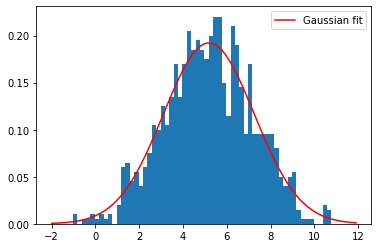

In [220]:
# we may now look at the fit:
bins = plt.hist(X_ground_truth, bins=np.arange(min(X_ground_truth), max(X_ground_truth) + binwidth, binwidth),
               density=True)
x_ = np.arange(-2,12,.1)
plt.plot(x_, norm.pdf(x_,problem.mu.numpy(),problem.sigma.numpy()), color='red', label='Gaussian fit')
plt.legend()